#Imports

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib as mpl
import matplotlib.pyplot as plt

## **Part (1)**

In [ ]:
original_img = cv2.imread("/content/original rgb.png")

##Converting to Gray Scale

In [ ]:
gray_scale = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

##Applying Median Filter

In [ ]:
median_filter = cv2.medianBlur(gray_scale,5)

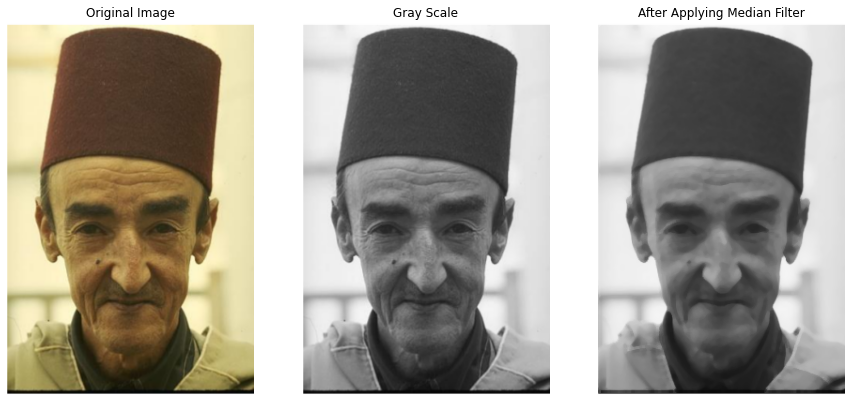

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,15))
ax=ax.flatten()
ax[0].imshow(cv2.cvtColor(original_img , cv2.COLOR_BGR2RGB));
ax[0].title.set_text("Original Image");
ax[0].axis("off");
ax[1].imshow(cv2.cvtColor(gray_scale, cv2.COLOR_BGR2RGB));
ax[1].title.set_text("Gray Scale");
ax[1].axis("off");
ax[2].imshow(cv2.cvtColor(median_filter, cv2.COLOR_BGR2RGB));
ax[2].title.set_text("After Applying Median Filter");
ax[2].axis("off");

#Applying Laplacian Filter

In [ ]:
laplacian = cv2.Laplacian(median_filter, 2, ksize=5)

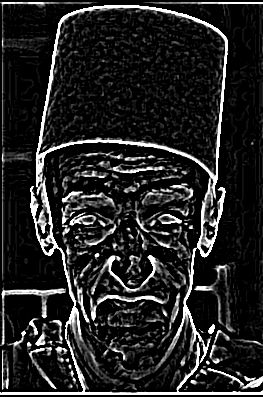

In [ ]:
cv2_imshow(laplacian)

##Binary Inverse Thresholding

In [ ]:
_,binary_inverse = cv2.threshold(laplacian, 127, 255,cv2.THRESH_BINARY_INV)

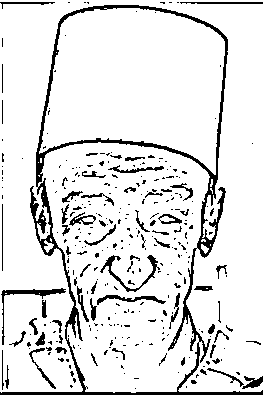

In [ ]:
cv2_imshow(binary_inverse)

##Bilateral Filter on Original Image

In [ ]:
copy = original_img
def bilateral(img,num=1):
  for i in range(num):
    img = cv2.bilateralFilter(original_img, 9, 30,30)
  return img  

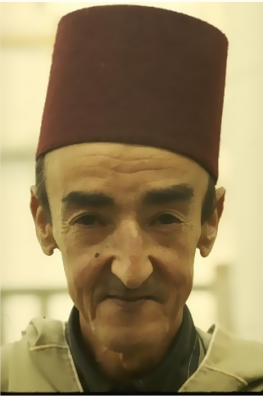

In [ ]:
bilateral_filter = bilateral(copy,5)
cv2_imshow(bilateral_filter)

# Overlaying the edge mask

In [ ]:
new_edge = cv2.imwrite('binary_inverse.jpg', binary_inverse)

In [ ]:
new_edge = cv2.imread('binary_inverse.jpg')

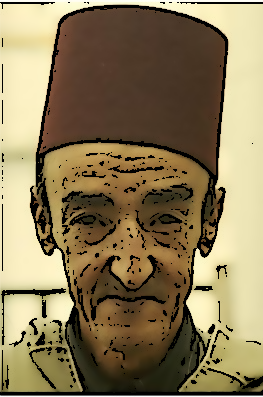

In [ ]:
dest=cv2.addWeighted(bilateral_filter, 1, new_edge,1, -255)
cv2_imshow(dest)

# **Part (2)**

# Reading the image

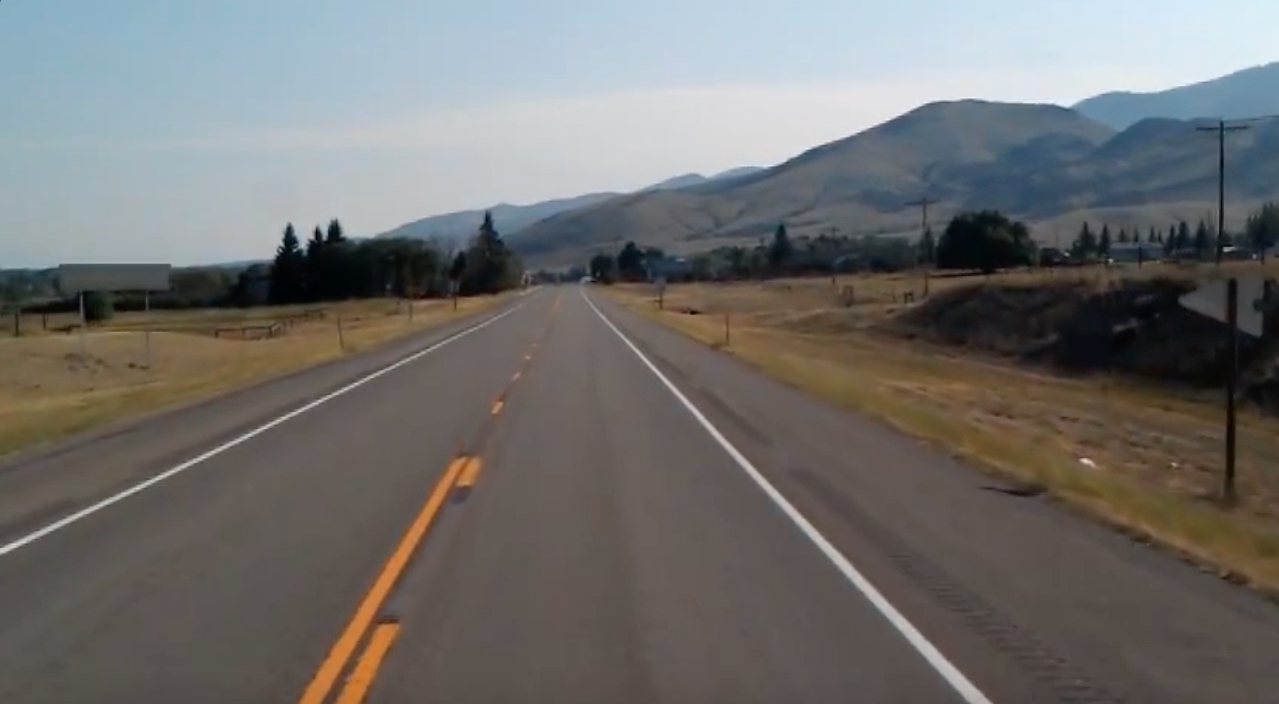

In [ ]:
road_img = cv2.imread('/content/testHough.jpg')
cv2_imshow(road_img)

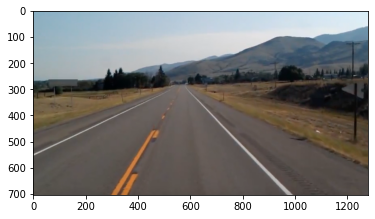

In [ ]:
rgb_road_img = cv2.cvtColor(road_img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_road_img)

# Smoothing the image

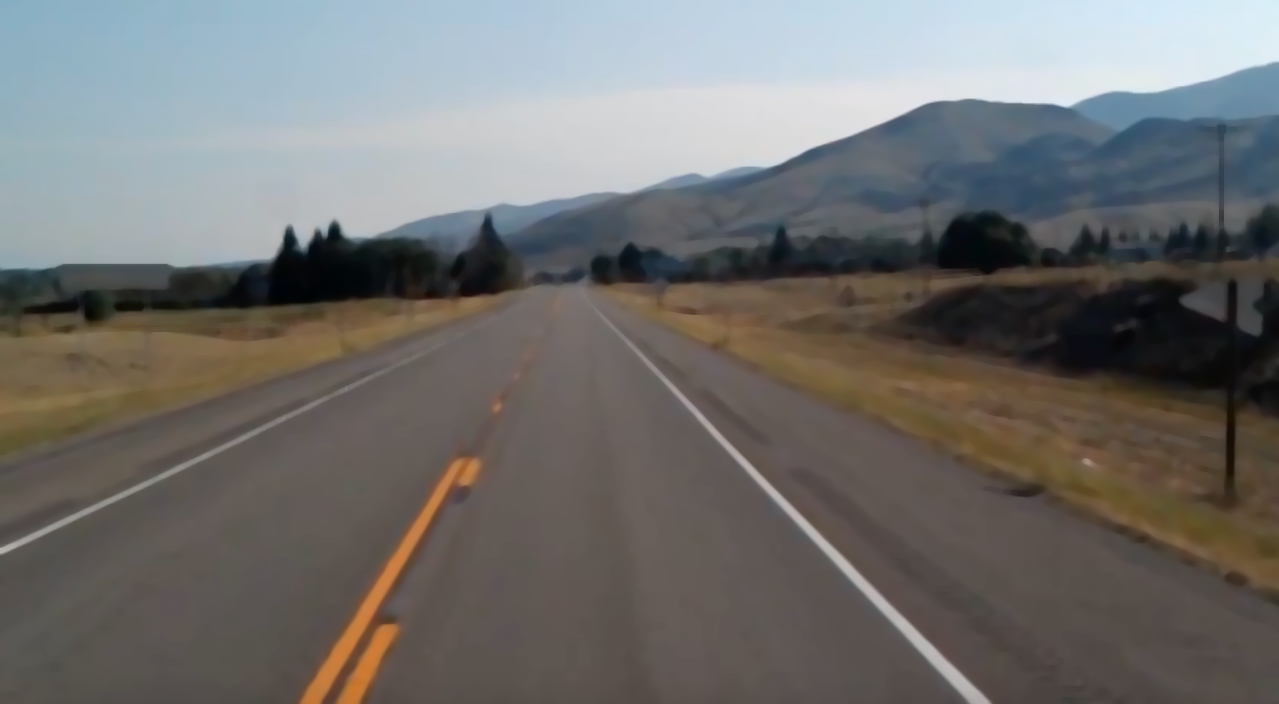

In [ ]:
smoothed_img = cv2.medianBlur(road_img, ksize=9)
cv2_imshow(smoothed_img)

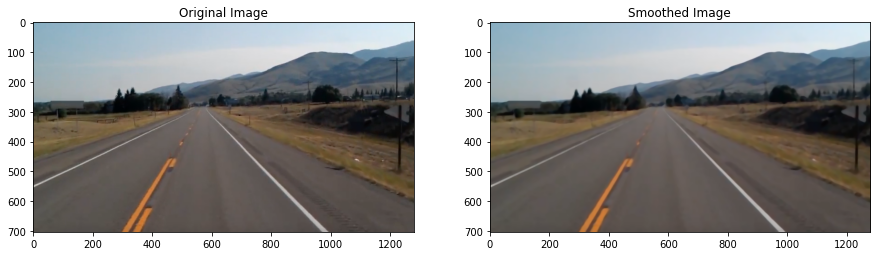

In [ ]:
rgb_smoothed_img = cv2.cvtColor(smoothed_img, cv2.COLOR_BGR2RGB)

f, axis = plt.subplots(1, 2, figsize=(15,15))
axis[0].imshow(rgb_road_img)
axis[0].title.set_text("Original Image");
axis[1].imshow(rgb_smoothed_img)
axis[1].title.set_text("Smoothed Image");

# Canny edge Detection

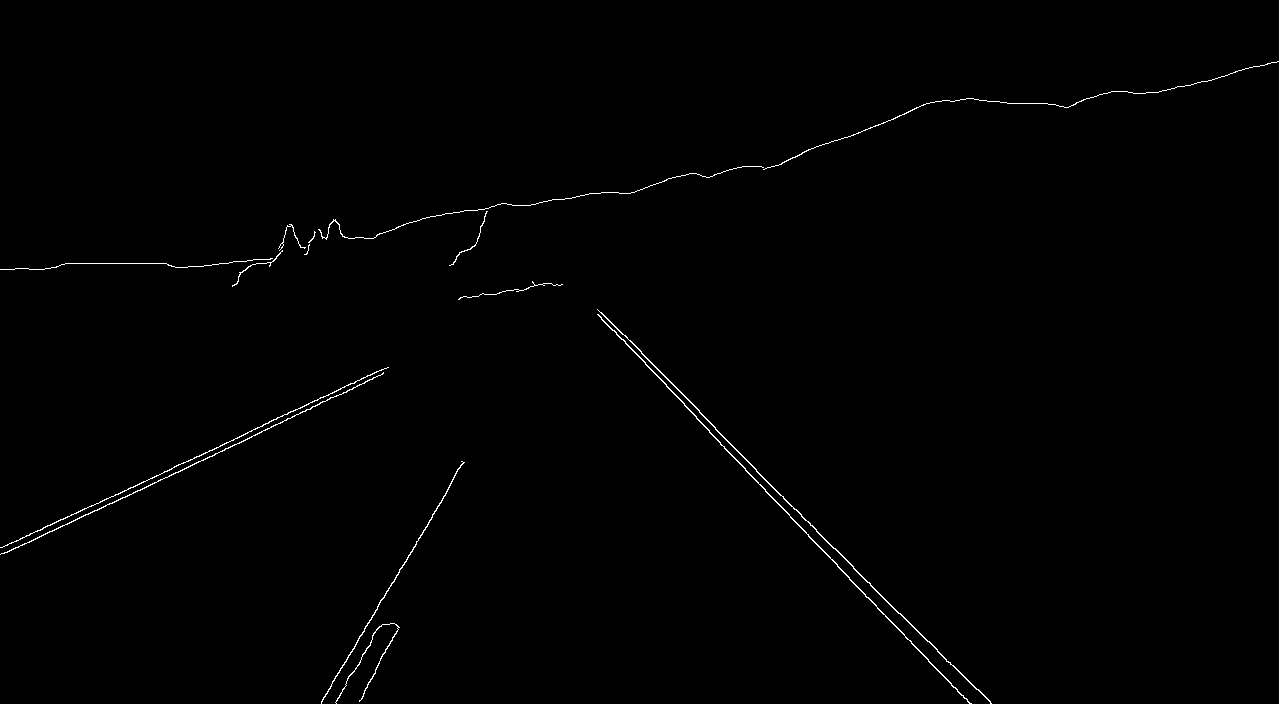

In [ ]:
img_edges = cv2.Canny(rgb_smoothed_img, 50, 250)
cv2_imshow(img_edges);

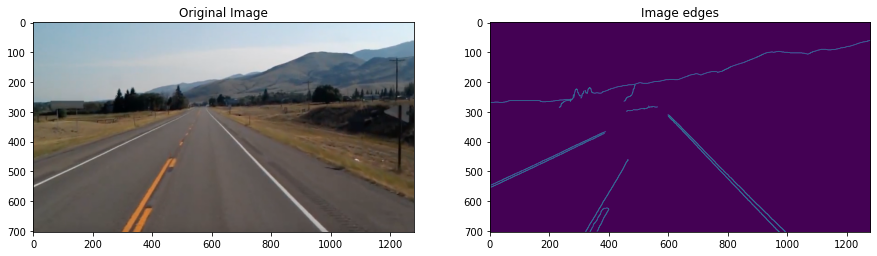

In [ ]:
f, axis = plt.subplots(1, 2, figsize=(15,15))

axis[0].imshow(rgb_road_img)
axis[0].title.set_text("Original Image");
axis[1].imshow(img_edges)
axis[1].title.set_text("Image edges");

# Region Of Interest

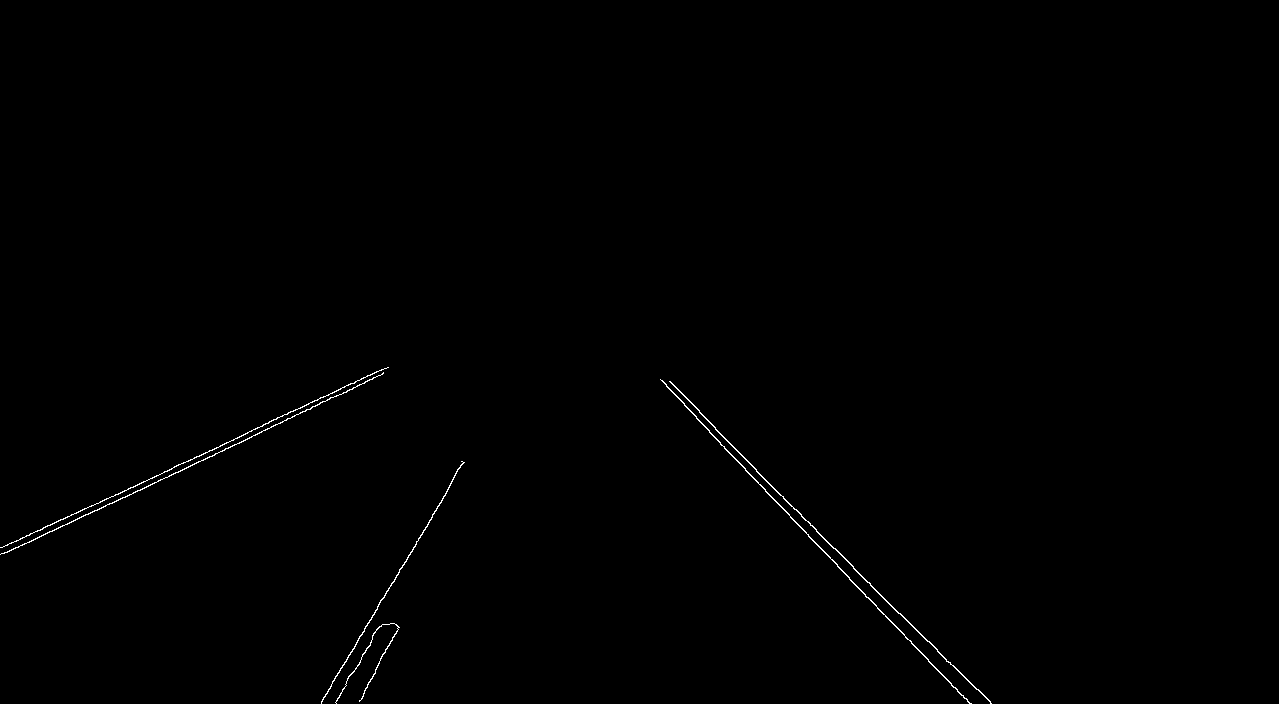

In [ ]:
img_edges_ROI = img_edges.copy()

height = img_edges_ROI.shape[0]
#polygon used is a triangle as it's the most suitable for 
#cropping out the 3 lanes only
polygon = np.array([[(-100, height), (2500, height), (100, 280)]])
mask = np.zeros_like(img_edges)
cv2.fillPoly(mask, polygon, 255)
masked_img = cv2.bitwise_and(img_edges, mask)

cv2_imshow(masked_img)

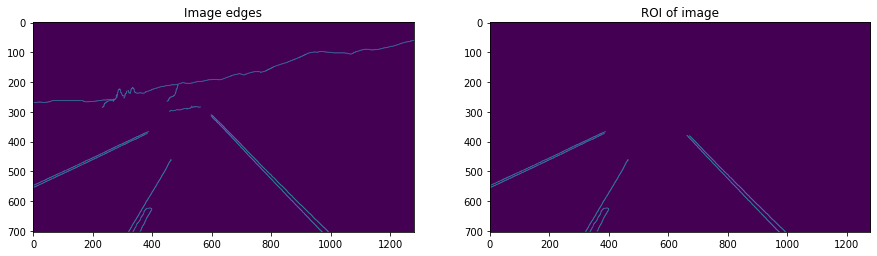

In [ ]:
f, axis = plt.subplots(1, 2, figsize=(15,15))

axis[0].imshow(img_edges)
axis[0].title.set_text("Image edges");
axis[1].imshow(masked_img)
axis[1].title.set_text("ROI of image");

# Accumulation into (ρ, θ)-space using Hough transform and refining

In [ ]:
def hough(img, threshhold = 100):
    rhos =[]
    thetas = []
    theta = np.arange(0,180)
    x, y = img.shape
    diag_len = int((np.ceil(np.sqrt((x)**2 + (y)**2))))
    accumulator = np.zeros((diag_len, len(theta)))
    
    for i in range(x):
        for j in range(y):
            if img[i][j]==255:
                for th in theta:
                    rho = j* np.cos((th*(np.pi/180))) + i * np.sin((th*(np.pi/180)))
                    rho = round((rho))                  
                    accumulator[int(rho)][th] = accumulator[int(rho)][th] + 1

                    #looking for the highest peaks of the accumulator function
                    if accumulator[int(rho)][th] >= threshhold:
                        rhos.append(int(rho))
                        thetas.append(th) 
                                          
    return rhos, thetas, accumulator

# Refining Coordinates and HT Post-Processing

In [ ]:
def detect_lanes(img, masked_img, polygon):
  rho, thetaa, H = hough(masked_img)

  masked_img = cv2.cvtColor(masked_img,cv2.COLOR_GRAY2RGB)        
  for i in range(len(rho)):
      rh = rho[i]
      theta = np.deg2rad(thetaa[i])
      a = np.cos(theta)
      b = np.sin(theta)
      x0 = a*rh
      y0 = b*rh

      x1 = int(x0 + 1500*(-b))
      y1 = int(y0 + 1500*(a))
      x2 = int(x0 - 1500*(-b))
      y2 = int(y0 - 1500*(a))

      cv2.line(masked_img,(x1,y1),((x2),y2),(255,0,0),3)

  mask = np.zeros_like(masked_img)
  cv2.fillPoly(mask, polygon, 255) 
  masked_image = cv2.bitwise_and(masked_img, mask)

  #backtorgb = cv2.cvtColor(masked_image,cv2.COLOR_GRAY2RGB)
  output = cv2.addWeighted(img,0.7,masked_image,0.7,0)
  cv2_imshow(output)

# Lanes detected

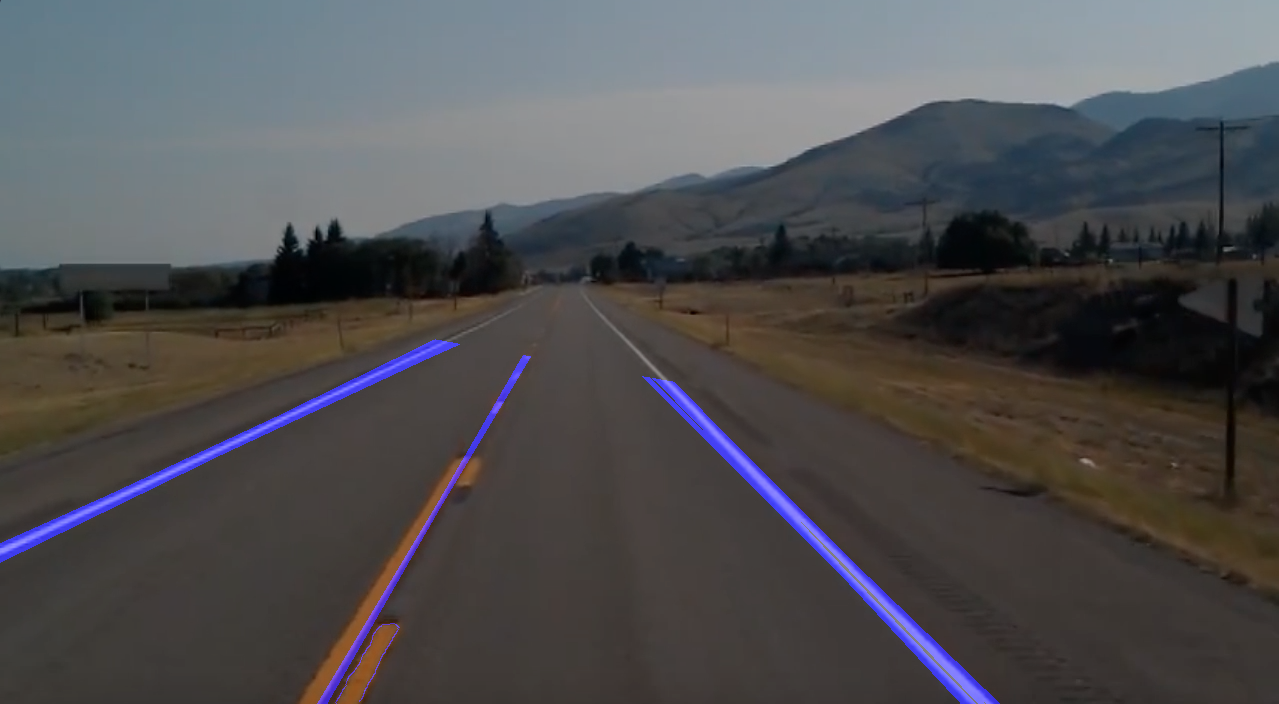

In [ ]:
detect_lanes(road_img, masked_img, polygon)

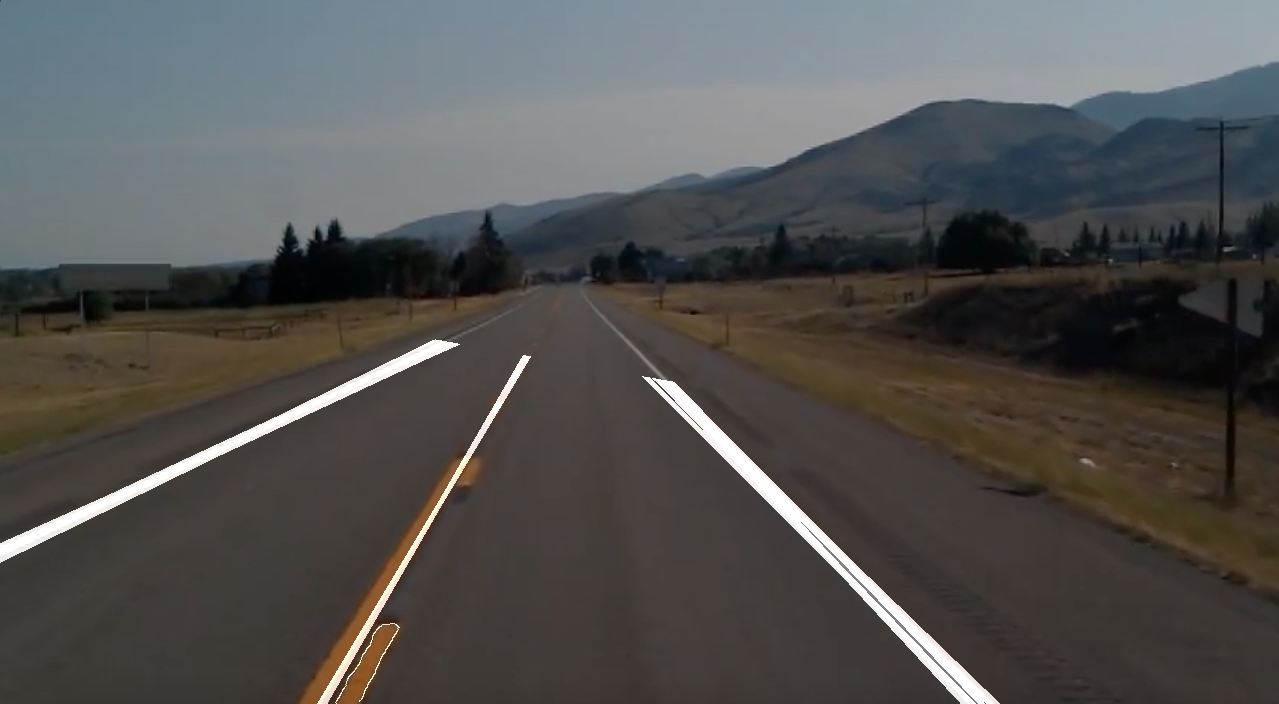

In [ ]:
detect_lanes(road_img, masked_img, polygon)

# **Improvment**

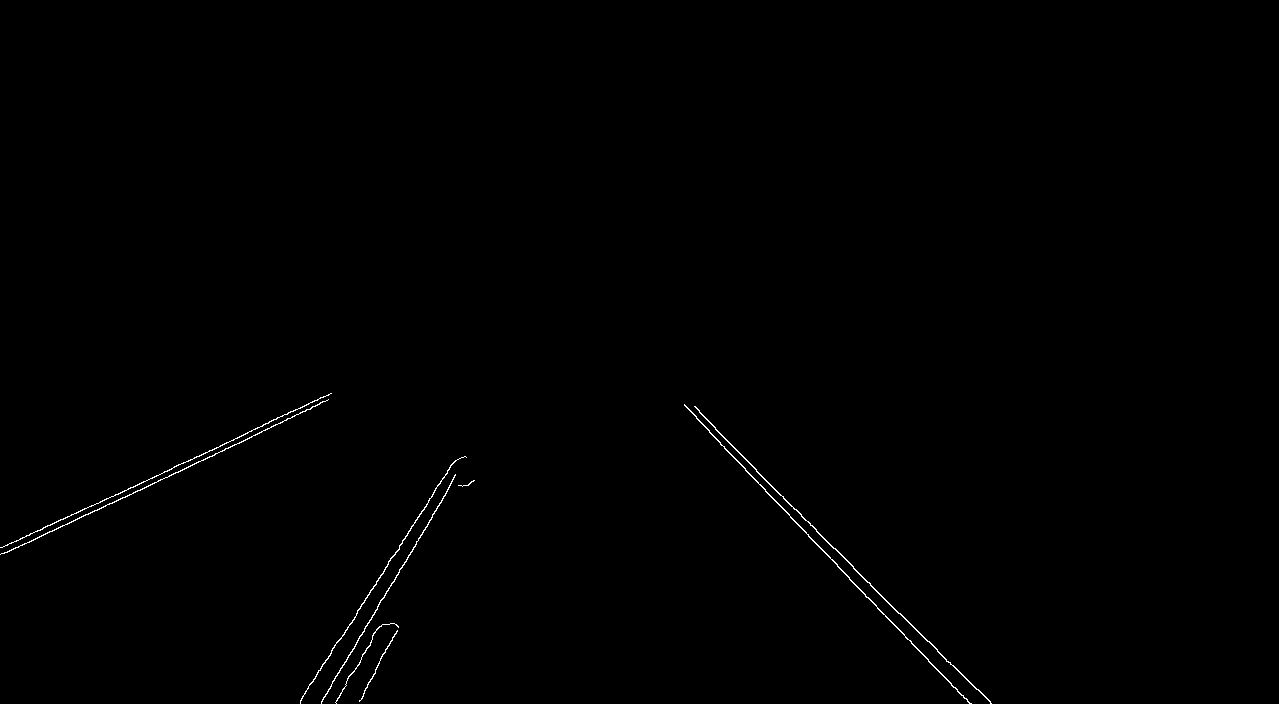

In [ ]:
img_edges = cv2.Canny(rgb_smoothed_img, 100, 200)

img_edges_ROI = img_edges.copy()

height = img_edges_ROI.shape[0]
#polygin used is a triangle as it's the most suitable for 
#cropping out the 3 lanes only
polygon = np.array([[(-70, height), (2100, height), (100, 280)]])
mask = np.zeros_like(img_edges)
cv2.fillPoly(mask, polygon, 255)
masked_img = cv2.bitwise_and(img_edges, mask)

cv2_imshow(masked_img)

In [ ]:
def hough2(img,threshhold = 100):
    rhos=[]
    thetas = []
    theta = np.arange(0,180)
    x, y = img.shape
    max_dist = int((np.ceil(np.sqrt(x)**2 + (y)**2)))
    accumulator = np.zeros((max_dist, len(theta)))
    
    for i in range(x):
        for j in range(y):
            if img[i][j]==255:
                #accumulator function
                for th in theta:
                    rho = j* np.cos((th*(np.pi/180))) + i * np.sin((th*(np.pi/180)))
                    rho = round((rho))                  
                    accumulator[int(rho)][th] = accumulator[int(rho)][th] + 1

    for i in range(x):
      for j in range(y):
        #looking for the highest peaks of the accumulator function
        if accumulator[int(rho)][th] >= threshhold:
              rhos.append(int(rho))
              thetas.append(th) 
        #performing non-maximum suppression for lower values
        else:
              accumulator[int(rho)][th] = 0           
                                          
    return rhos, thetas, accumulator

In [ ]:
def detect_lanes2(img, masked_img, polygon):
  rhos, thetas, H = hough2(masked_img)
          
  for i in range(len(rhos)):
      rho = rhos[i]
      theta = np.deg2rad(thetas[i])
      a = np.cos(theta)
      b = np.sin(theta)
      x0 = a*rho
      y0 = b*rho

      x1 = int(x0 + 1000*(-b))
      y1 = int(y0 + 1000*(a))
      x2 = int(x0 - 1000*(-b))
      y2 = int(y0 - 1000*(a))

      cv2.line(masked_img,(x1,y1),((x2),y2),(255,0,0),3)

  mask = np.zeros_like(masked_img)
  cv2.fillPoly(mask, polygon, 255) 
  masked_image = cv2.bitwise_and(masked_img, mask)

  backtorgb = cv2.cvtColor(masked_image,cv2.COLOR_GRAY2RGB)
  output = cv2.addWeighted(img,0.7,backtorgb,0.7,0)
  cv2_imshow(output)

# Lanes detected improved

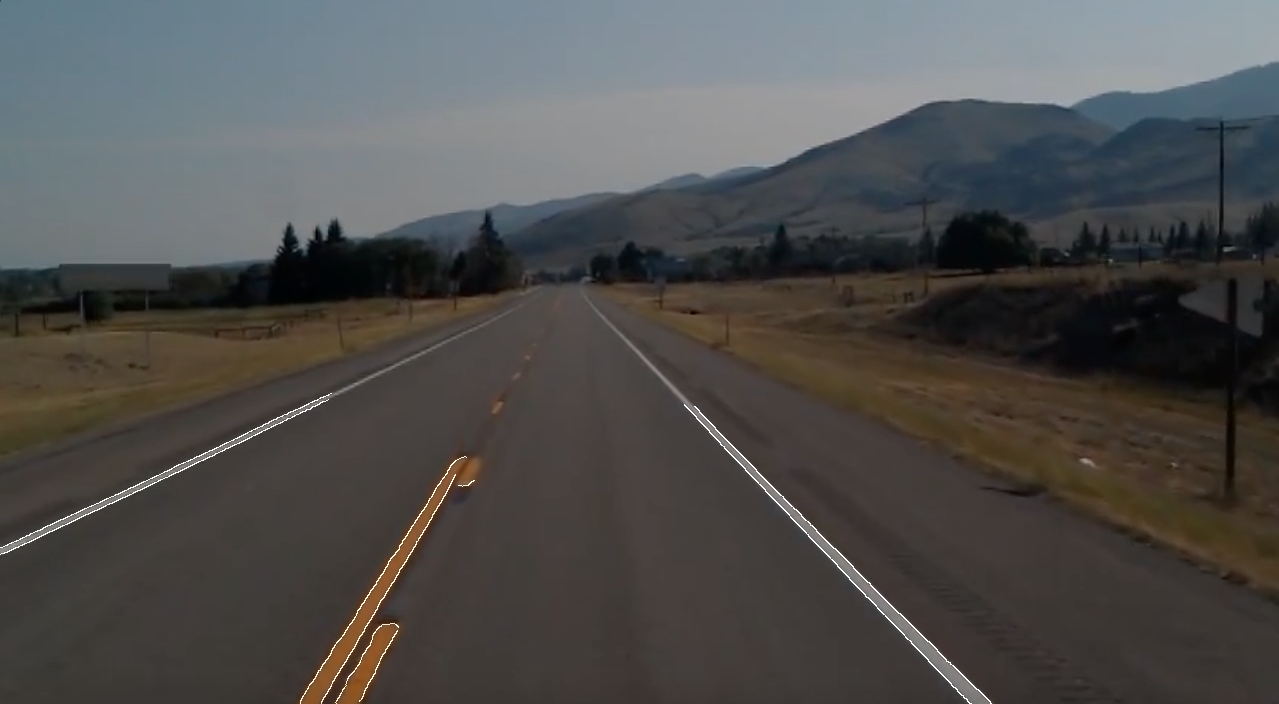

In [ ]:
detect_lanes2(road_img, masked_img, polygon)

# **Testing another image**

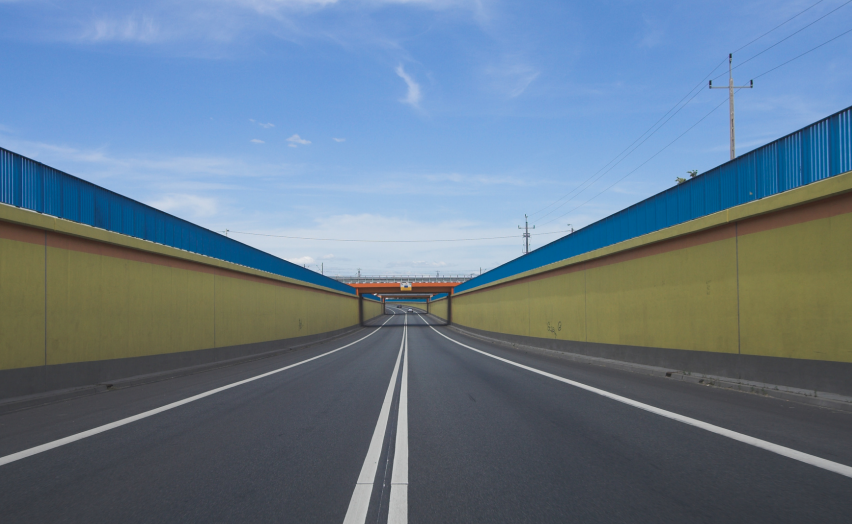

In [ ]:
road_img1 = cv2.imread('/content/testHough1.png')
cv2_imshow(road_img1)

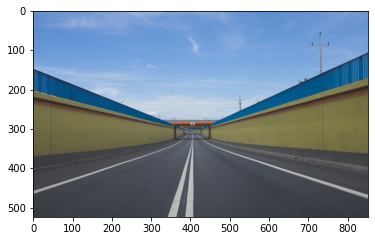

In [ ]:
rgb_road_img1 = cv2.cvtColor(road_img1, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_road_img1)

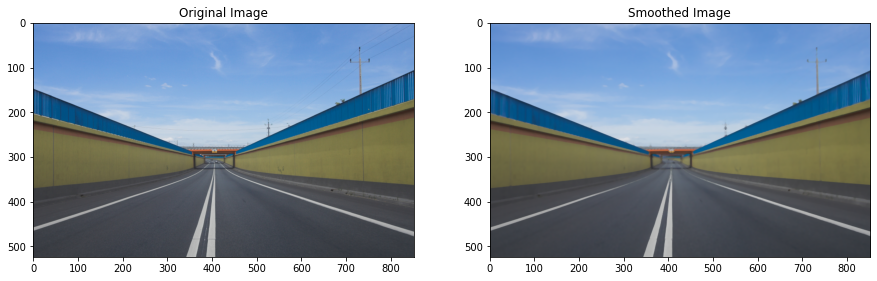

In [ ]:
smoothed_img1 = cv2.medianBlur(road_img1, ksize=5)

rgb_smoothed_img1 = cv2.cvtColor(smoothed_img1, cv2.COLOR_BGR2RGB)

f, axis = plt.subplots(1, 2, figsize=(15,15))
axis[0].imshow(rgb_road_img1)
axis[0].title.set_text("Original Image");
axis[1].imshow(rgb_smoothed_img1)
axis[1].title.set_text("Smoothed Image");

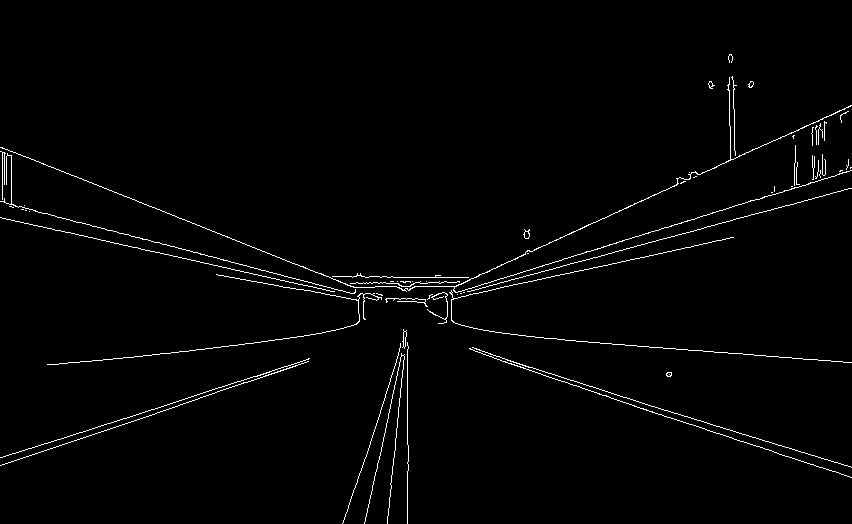

In [ ]:
img_edges1 = cv2.Canny(rgb_smoothed_img1, 100, 200)
cv2_imshow(img_edges1);

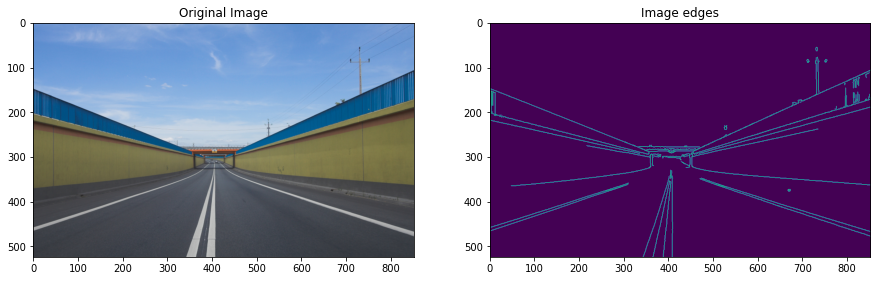

In [ ]:
f, axis = plt.subplots(1, 2, figsize=(15,15))

axis[0].imshow(rgb_road_img1)
axis[0].title.set_text("Original Image");
axis[1].imshow(img_edges1)
axis[1].title.set_text("Image edges");

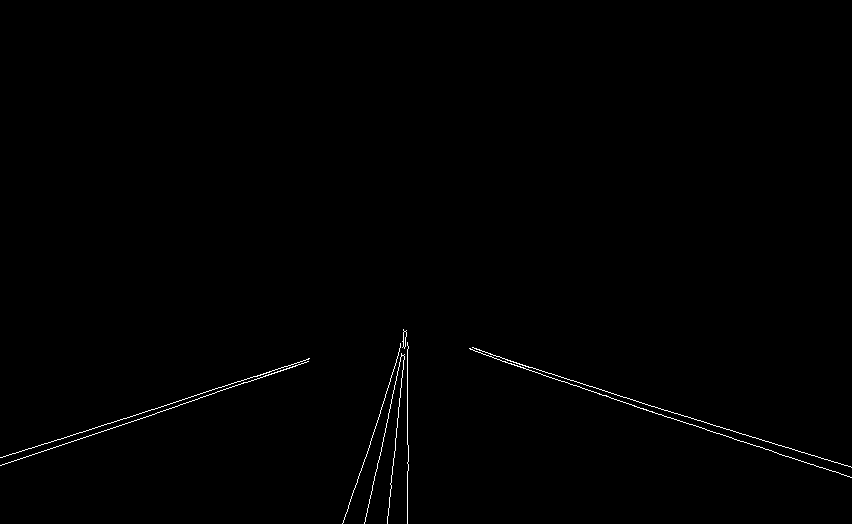

In [ ]:
img_edges_ROI1 = img_edges1.copy()

height1 = img_edges_ROI1.shape[0]
#polygon used is a triangle as it's the most suitable for 
#cropping out the 3 lanes only
polygon1 = np.array([[(-300, height1), (1300, height1), (400, 320)]])
mask1 = np.zeros_like(img_edges1)
cv2.fillPoly(mask1, polygon1, 255)
masked_img1 = cv2.bitwise_and(img_edges1, mask1)

cv2_imshow(masked_img1)

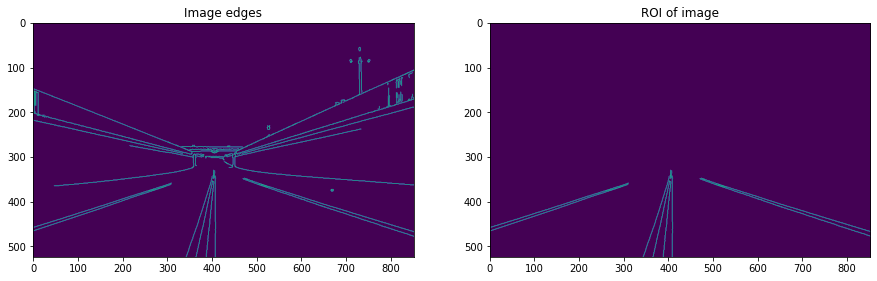

In [ ]:
f, axis = plt.subplots(1, 2, figsize=(15,15))

axis[0].imshow(img_edges1)
axis[0].title.set_text("Image edges");
axis[1].imshow(masked_img1)
axis[1].title.set_text("ROI of image");

# Detected lanes before improvement

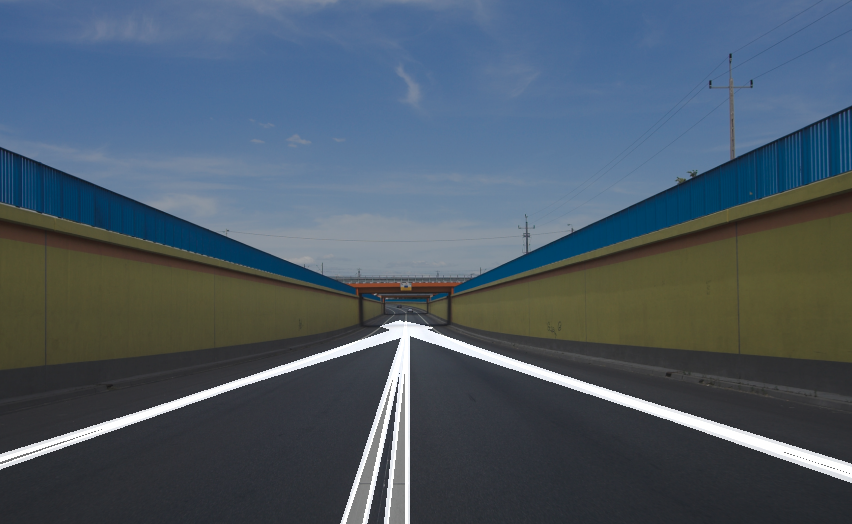

In [ ]:
detect_lanes(road_img1, masked_img1, polygon1)

# Detected lanes after improvement

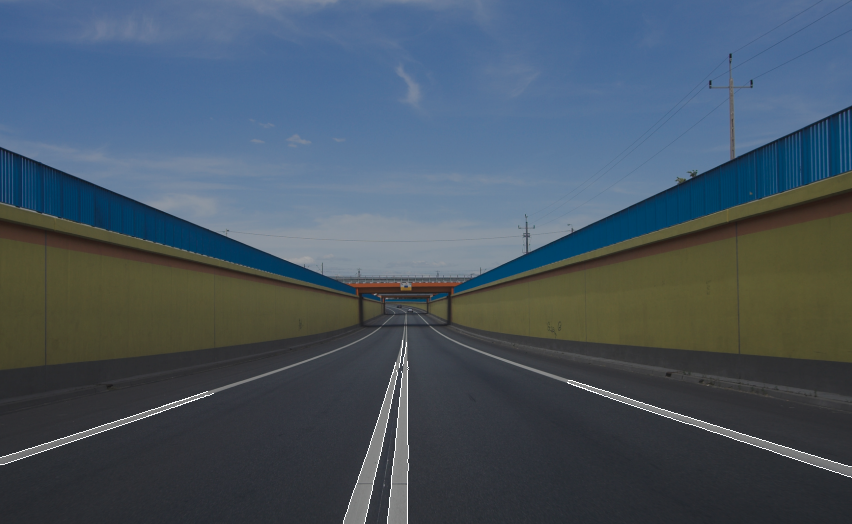

In [ ]:
detect_lanes2(road_img1, masked_img1, polygon1)